Import

In [1]:
import os
import numpy as np
import pandas as pd
from numba import jit
import random
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict


Paths

In [2]:
input_folder = '../data/weibo_preprocessed/'
output_folder = '../data/weibo_features/'

user_profile_path = input_folder + "userProfile.pkl"
labels_path = input_folder + "labels2_all_200.pkl"
edges_path = input_folder + "edges2_all_200.pkl"
infos_influencers_path = input_folder + "infos_influencers_3.pkl"
infos_targets_path = input_folder + "infos_targets_3.pkl"

Objective of this file 

Input : 

    user_profile : contains all profile features
    labels : contains ground_truth influences of subsampled cascades
    edges : contains induced graph topology of subsampled cascades
    infos_influencers : contains topic averages of all influencers
    infos_targets : contains topic averages of all targets
    influencers_emb_path : contains IMINFECTOR embeddings of 25K influencers
    targets_emb_path : contains IMINFECTOR embeddings of 1.1M targets

Output : 

    features_influencers : contains all features of the subsampled influencers
    features_targets : contains all features of the subsampled targets


import user_profile

In [3]:
user_profile = pd.read_pickle(user_profile_path)
#df_user_orig.index = df_user_orig['id'].astype(np.int64)

print(f"user_profile : \n{user_profile.dtypes}")
print(f"shape : {user_profile.shape}\n" )


AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from 'c:\\Users\\Mario\\.conda\\envs\\greedy\\lib\\site-packages\\pandas\\core\\internals\\blocks.py'>

Preprocessing of user profiles

In [4]:
features_user_profile = ['followers_count', 'friends_count', 'statuses_count', 'verified', 'gender']

user_profile.index = user_profile.uid
user_profile = user_profile[features_user_profile]
user_profile['followers_count'] = user_profile['followers_count'].apply(lambda x : np.log(max(x, 0) + 1)) / 10
user_profile['friends_count']   = user_profile['friends_count'].apply(lambda x : np.log(max(x, 0) + 1)) / 8
user_profile['statuses_count']  = user_profile['statuses_count'].apply(lambda x : np.log(max(x, 0) + 1)) / 10
user_profile['verified']        = user_profile.verified.cat.codes
user_profile['gender']          = user_profile.gender.cat.codes
#user_profile                    = user_profile.groupby(user_profile.index).first() #some userid were 2 time in the dataset 1681085 rows -> 1655678 rows

print("df_user : \n" + user_profile.head(4).to_markdown())
print(f"shape : {user_profile.shape}\n" )


df_user : 
|        uid |   followers_count |   friends_count |   statuses_count |   verified |   gender |
|-----------:|------------------:|----------------:|-----------------:|-----------:|---------:|
| 1657151084 |          0.352636 |        0.636719 |         0        |          0 |        1 |
| 1657149732 |          0.283321 |        0.416526 |         0.248491 |          0 |        1 |
| 1657148500 |          0.438203 |        0.42515  |         0.32581  |          0 |        1 |
| 1657146942 |          0.270805 |        0.310613 |         0.138629 |          0 |        1 |
shape : (1681085, 5)



Network features estimation

In [3]:
edges = pd.read_pickle(edges_path)

import networkx as nx

def f(): return 0
d_edges = defaultdict(f)
for (u,v) in zip(edges.u, edges.v) :
    d_edges[(u,v)] = 1

deg_out = edges.groupby('u').count()
d_deg_out= defaultdict(lambda : 0)
for u in deg_out.index :
    d_deg_out[u] = deg_out.loc[u].v

deg_in = edges.groupby('v').count()
d_deg_in= defaultdict(lambda : 0)
for v in deg_in.index : 
    d_deg_in[v] = deg_in.loc[v].u


In [6]:
g = nx.DiGraph()
g.add_edges_from(zip(edges.u, edges.v))

pagerank = nx.pagerank(g)
pagerank = pd.DataFrame.from_dict(pagerank, orient='index')
pagerank = pagerank / 0.00011 
pagerank.columns = ['pagerank']

In [7]:
# pagerank = pagerank / 0.1
pagerank.mean()

pagerank    1.001863
dtype: float64

In [8]:
d_2g = defaultdict(lambda : 0)
influencers = edges.groupby('u').count().index
for i in influencers : 
    set_2neighboors = set()
    for n in nx.DiGraph.neighbors(g,i) : 
        set_2neighboors = set_2neighboors.union(set([n2 for n2 in nx.DiGraph.neighbors(g,n)]))
    d_2g[i] = len(set_2neighboors)
    # print(len(set_2neighboors))
df_2reachable = pd.DataFrame.from_dict(d_2g, orient='index')
df_2reachable = df_2reachable / 2500
df_2reachable.columns = ['#2r']

Topic informations

In [6]:
infos_influencers = pd.read_pickle(infos_influencers_path)
infos_targets = pd.read_pickle(infos_targets_path)

# infos coming from cascades
infos_influencers = infos_influencers[[0,1,2]] # remove infos coming from cascades
# infos_influencers['total_likes'] = infos_influencers['total_likes'].apply(lambda x : np.log(max(x, 0) + 1)) / 17
# infos_influencers['total_reposts']   = infos_influencers['total_reposts'].apply(lambda x : np.log(max(x, 0) + 1)) / 13
# infos_influencers['n_cascades']  = infos_influencers['n_cascades'].apply(lambda x : np.log(max(x, 0) + 1)) / 8

print("infos_influencers : \n" + infos_influencers.head(4).to_markdown())
print(f"shape : {infos_influencers.shape}\n" )


infos_influencers : 
|   userid |        0 |        1 |        2 |
|---------:|---------:|---------:|---------:|
|    10029 | 0.222222 | 0.619048 | 0.15873  |
|    10111 | 0.183333 | 0.633333 | 0.183333 |
|    10145 | 0.188679 | 0.603774 | 0.207547 |
|    10452 | 0.192308 | 0.615385 | 0.192308 |
shape : (47555, 3)



Build Influencers/Targets features tables

In [11]:
labels = pd.read_pickle(labels_path)
influencers = list(labels.groupby('u').count().index)
targets = list(labels.groupby('v').count().index)

print(f"sizes from label : \nI = {len(influencers)}\nT = {len(targets)}")

#add user profile features
# features_influencers = user_profile.loc[user_profile.index.intersection(influencers)]
# features_targets = user_profile.loc[user_profile.index.intersection(targets)]

# features_influencers = features_influencers.groupby(features_influencers.index).first()
# features_targets = features_targets.groupby(features_targets.index).first()

features_influencers = pd.DataFrame(influencers, index=influencers)
features_targets = pd.DataFrame(targets, index=targets)

#add topology features

features_influencers['d_out'] = pd.Series(features_influencers.index, index=features_influencers.index).apply(lambda uid : np.log(d_deg_out[uid] + 1) / 8)
features_targets['d_in'] = pd.Series(features_targets.index, index=features_targets.index).apply(lambda uid : np.log(d_deg_in[uid] + 1) / 7)

features_influencers = features_influencers.merge(pagerank, left_on=features_influencers.index, right_on=pagerank.index).set_index('key_0')
features_targets = features_targets.merge(pagerank, left_on=features_targets.index, right_on=pagerank.index).set_index('key_0')

features_influencers = features_influencers.merge(df_2reachable, left_on=features_influencers.index, right_on=df_2reachable.index).set_index('key_0')

#add topic features
# features_influencers = features_influencers.merge(infos_influencers, left_on=features_influencers.index, right_on=infos_influencers.index).set_index('key_0')
# features_targets = features_targets.merge(infos_targets, left_on=features_targets.index, right_on=infos_targets.index).set_index('key_0')

print(f"sizes after feature extraction :\nI = {features_influencers.shape[0]}\nT = {features_targets.shape[0]}")


sizes from label : 
I = 8000
T = 1161
sizes after feature extraction :
I = 7907
T = 1160


In [16]:
# features_influencers = features_influencers.drop(columns=0)
features_targets = features_targets.drop(columns=0)

Saving tables

In [ ]:
features_influencers.to_pickle(output_folder + "features_influencers_all_200_twitter.pkl")
features_targets.to_pickle(output_folder + "features_targets_all_200_twitter.pkl")

Creation of embedding features

In [9]:
labels = pd.read_pickle(labels_path)
influencers = set(labels.groupby('u').count().index)
targets = set(labels.groupby('v').count().index)
targets_emb = pd.read_pickle(targets_emb_path)
influencers_emb = pd.read_pickle(influencers_emb_path)

print(f"sizes from label : \nI = {len(influencers)}\nT = {len(targets)}")

#selects embeddings 
features_influencers = influencers_emb.loc[influencers_emb.index.intersection(influencers)]
features_targets = targets_emb.loc[targets_emb.index.intersection(targets)]

features_influencers = features_influencers.groupby(features_influencers.index).first()
features_targets = features_targets.groupby(features_targets.index).first()

print(f"sizes after feature extraction :\nI = {features_influencers.shape[0]}\nT = {features_targets.shape[0]}")

features_influencers.to_pickle(output_folder + "embeddings_influencers_all_200.pkl")
features_targets.to_pickle(output_folder + "embeddings_targets_all_200.pkl")

sizes from label : 
I = 8000
T = 1161
sizes after feature extraction :
I = 6033
T = 1136


### Plots

In [83]:
df_u = user_profile.sample(n = 10000)
df_u.drop_duplicates(inplace=True)

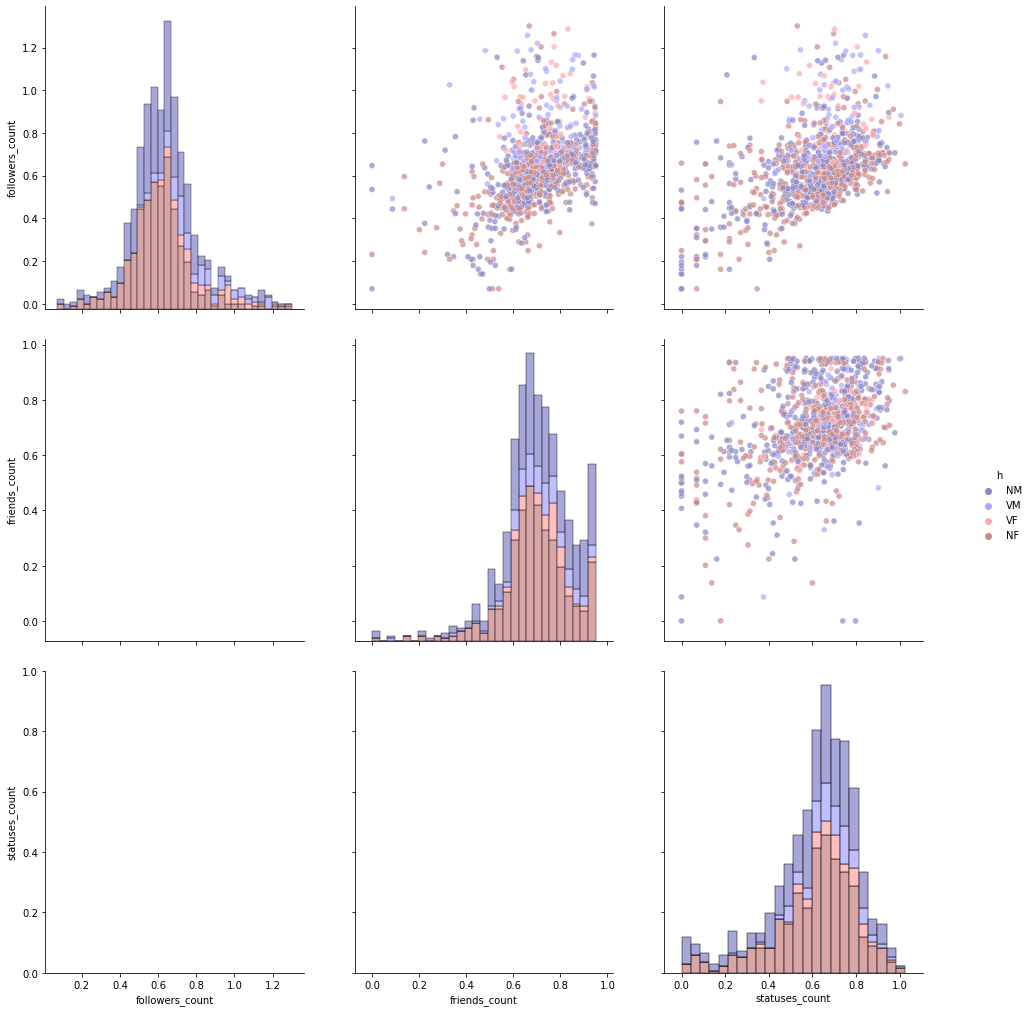

In [75]:
def f(t) :
    (a,b) = t
    if a == 1 and b == 1 : 
        return 'VM'
    elif a == 1 and b == 0 :
        return 'VF'
    elif a == 0 and b == 1 :
        return 'NM'
    else : return 'NF'

df_u['h'] = df_u[['verified', 'gender']].apply(tuple, axis=1).apply(f)
g = sns.PairGrid(   df_u[['followers_count','friends_count','statuses_count','h']], 
                    diag_sharey=False, 
                    hue='h',
                    palette={   'VM' : '#AAAAFF',
                                'VF' : '#FFAAAA',
                                'NM' : '#8888CC',
                                'NF' : '#CC8888'},
                    )
g.map_upper(sns.scatterplot, alpha=0.7)
#g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, multiple = 'stack')
g.add_legend()
g.fig.set_size_inches(15,15)


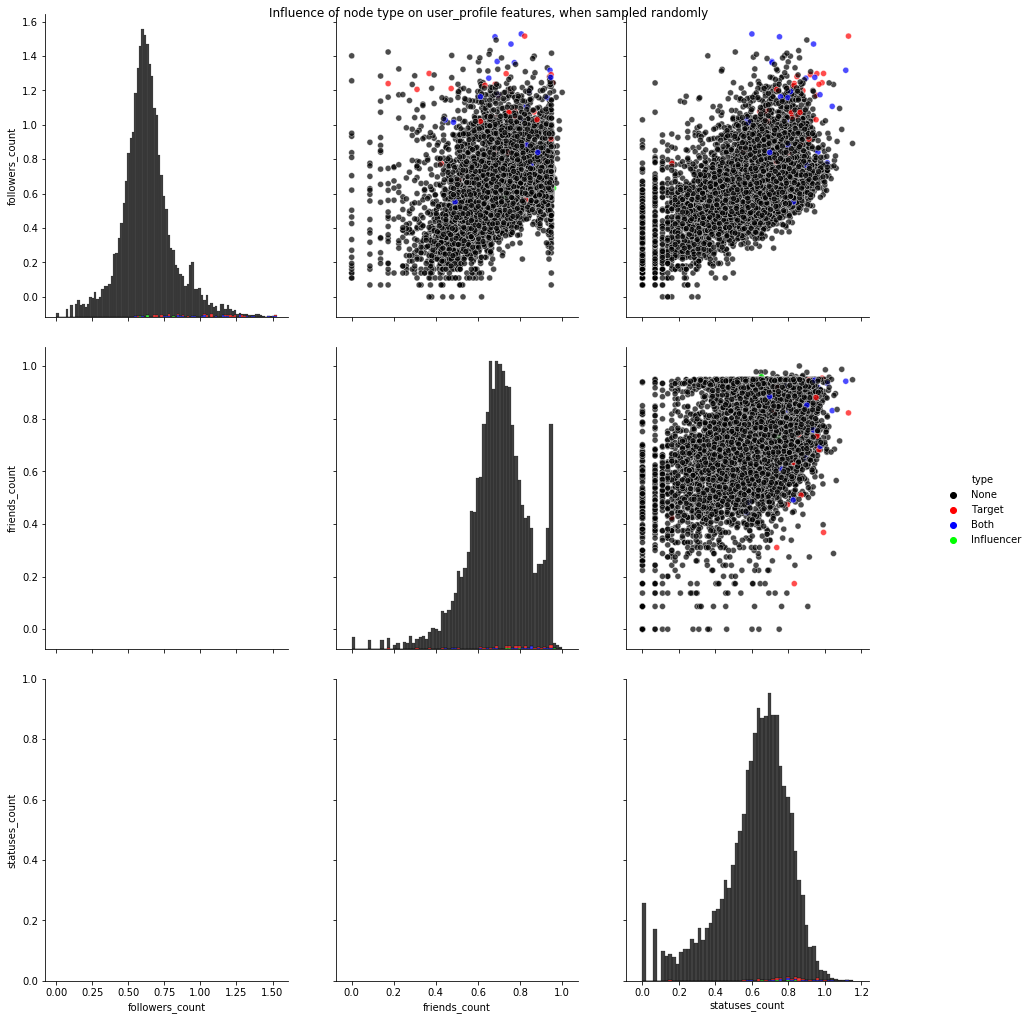

In [104]:
df_u = user_profile.sample(n = 10000)
df_u.drop_duplicates(inplace=True)

def classify(uid) :
    if d_deg_in[uid] > 0 and d_deg_out[uid] > 0:
        return "Both"
    elif d_deg_out[uid] > 0 :
        return "Target" 
    elif d_deg_in[uid] > 0 :
        return "Influencer"
    else : return "None"

df_u = df_u.reset_index()
df_u['type'] = df_u.uid.apply(classify)

g = sns.PairGrid(   df_u[['followers_count','friends_count','statuses_count','type']], 
                    diag_sharey=False, 
                    hue='type',
                    palette={   'Both' : '#0000FF',
                                'Target' : '#FF0000',
                                'Influencer' : '#00FF00',
                                'None' : '#000000'},
                    )
g.map_upper(sns.scatterplot, alpha=0.7)
#g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, multiple = 'stack')
g.add_legend()
g.fig.set_size_inches(15,15)
g.fig.suptitle('Influence of node type on user_profile features, when sampled randomly')
plt.show()

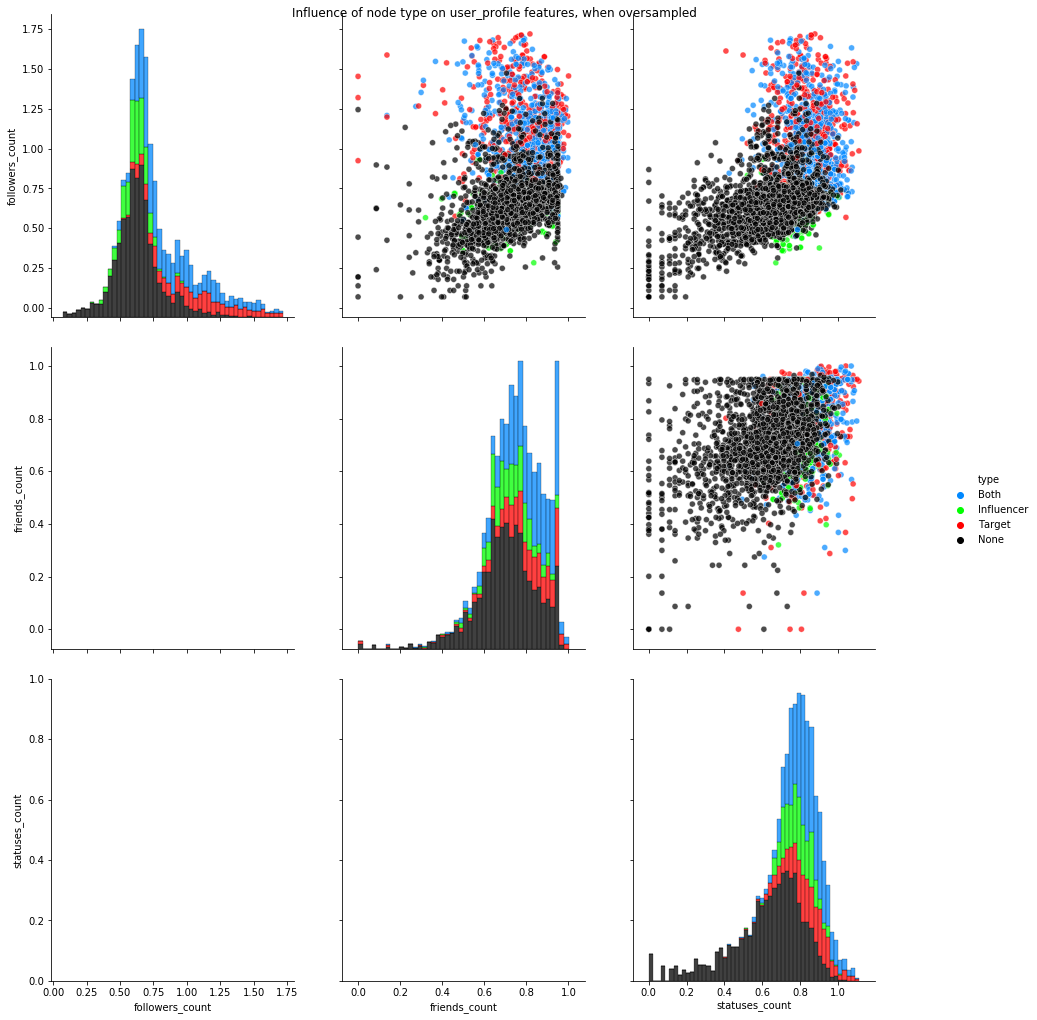

In [107]:
df_equ = pd.concat([user_profile.loc[influencers[:1000]], user_profile.loc[targets[:1000]], user_profile.sample(n=2000)])

df_equ = df_equ.reset_index()
df_equ['type'] = df_equ.uid.apply(classify)

g = sns.PairGrid(   df_equ[['followers_count','friends_count','statuses_count','type']], 
                    diag_sharey=False, 
                    hue='type',
                    palette={   'Both' : '#0088FF',
                                'Target' : '#FF0000',
                                'Influencer' : '#00FF00',
                                'None' : '#000000'},
                    )
g.map_upper(sns.scatterplot, alpha=0.7)
#g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, multiple = 'stack')
g.add_legend()
g.fig.suptitle("Influence of node type on user_profile features, when oversampled")
g.fig.set_size_inches(15,15)

In [137]:
features_influencers

,followers_count,friends_count,statuses_count,verified,gender,d_out,0,1,2,3,4,5,6,7
key_0,,,,,,,,,,,,,,
41499,0.936040,0.886883,0.725630,0,1,0.223970,0.080128,0.107692,0.143590,0.426923,0.044872,0.080128,0.026923,0.089744
101713,0.635957,0.745768,0.821474,0,1,0.173287,0.086095,0.110254,0.150656,0.390701,0.064483,0.069310,0.025991,0.102510
200880,1.168199,0.938530,0.808672,1,1,0.320619,0.096125,0.153082,0.170782,0.360479,0.047878,0.067261,0.017621,0.086772
282555,1.054294,0.847632,0.809864,1,1,0.259930,0.076415,0.110221,0.163835,0.384372,0.045147,0.073769,0.027418,0.118824
314315,0.994343,0.622951,0.681235,0,1,0.086643,0.074538,0.111807,0.172332,0.386852,0.045617,0.078414,0.025045,0.105397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693029692,1.392108,0.874012,0.953365,0,0,0.354152,0.063218,0.143678,0.267241,0.313218,0.050287,0.063218,0.027299,0.071839
2693119412,1.318636,0.243239,0.834451,0,0,0.310613,0.083952,0.118067,0.206706,0.359800,0.044551,0.070409,0.026111,0.090404
2694359913,1.264211,0.703453,0.477912,0,0,0.638998,0.079957,0.144357,0.196964,0.353925,0.037144,0.078190,0.022286,0.087177


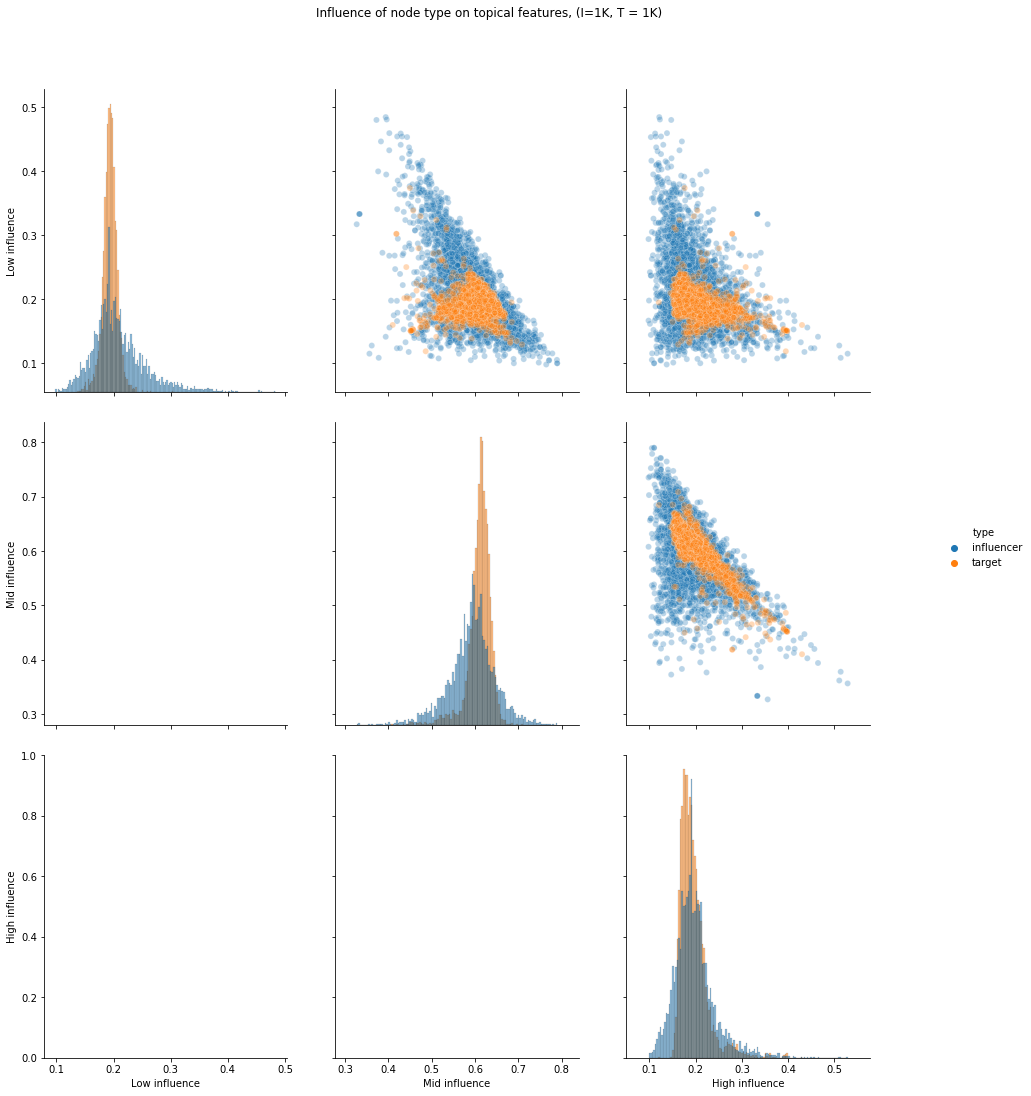

In [27]:
df1 = features_influencers.sample(n=5000)[[0,1,2]]
df2 = features_targets.sample(n=5000)[[0,1,2]]

df1['type'] = 'influencer'
df2['type'] = 'target'

df = pd.concat([df1, df2])
df = df.reset_index(drop=True)

df.columns = ['Low influence', 'Mid influence', 'High influence','type']
g = sns.PairGrid(   df,
                    diag_sharey=False, 
                    hue='type',
                    )
g.map_upper(sns.scatterplot, alpha=0.3)
#g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot,multiple='layer')
g.add_legend()
g.fig.suptitle("Influence of node type on topical features, (I=1K, T = 1K)", y=1.05)
g.fig.set_size_inches(15,15)

end